# Creating training masks with the `solaris` python API

You can create training masks from geojson-formatted labels with a single `solaris` command. Here, we'll go through creating masks using a sample image and geojson provided with `solaris`.

Solaris enables creation of four types of masks:

- [Polygon footprints](#polygon-footprints), for buildings or other objects
- [Polygon outlines](#polygon-edges), for outlines of buildings or other target objects
- [Polygon contact points](#polygon-contact-points), for places where polygons are closely apposed to one another (e.g. buildings in suburbs)
- [Road network masks](#road-network-masks), from linestring-formatted road networks

The first three options here can also be combined to make multi-channel training targets, [as many of the SpaceNet 4 competitors did](https://medium.com/the-downlinq/a-deep-dive-into-the-spacenet-4-winning-algorithms-8d611a5dfe25).

Let's start with creating building footprints.

## Polygon footprints

The [solaris.vector.mask.footprint_mask()](../../api/vector.rst#solaris.vector.mask.footprint_mask) function creates footprints from polygons, with 0s on the outside of the polygon and _burn\_value_ on the inside. The function's arguments:

- `df`: A `pandas.DataFrame` or `geopandas.GeoDataFrame` containing polygons in one column.
- `out_file`: An optional argument to specify a filepath to save outputs to.
- `reference_im`: A georegistered image covering the same geography as `df`. This is optional, but if it's not provided and you wish to convert the polygons from a geospatial CRS to pixel coordinates, you must provide `affine_obj`.
- `geom_col`: An optional argument specifying which column holds polygons in `df`. This defaults to `"geometry"`, the default geometry column in GeoDataFrames.
- `do_transform`: Should polygons be transformed from a geospatial CRS to pixel coordinates? `solaris` will try to infer whether or not this is necessary, but you can force behavior by providing `True` or `False` with this argument.
- `affine_obj`: An [affine](https://pypi.org/project/affine/) object specifying a transform to convert polygons from a geospatial CRS to pixel coordinates. This optional (unless `do_transform=True` and you don't provide `reference_im`), and is superceded by `reference_im` if that argument is also provided.
- `shape`: Optionally, the `(X, Y)` bounds of the output image. If `reference_im` is provided, the shape of that image supercedes this argument.
- `out_type`: Either `int` or `float`, the dtype of the output. Defaults to `int`.
- `burn_value`: The value that pixels falling within the polygon will be set to. Defaults to `255`.
- `burn_field`: Optionally, a column within `df` that specifies the value to set for each individual polygon. This can be used if you have multiple classes.

Let's make a mask! We'll use `sample_geotiff.tif` from the sample data and `geotiff_labels.geojson` for polygons. First, we'll open those two objects up so you can see what we're working with.

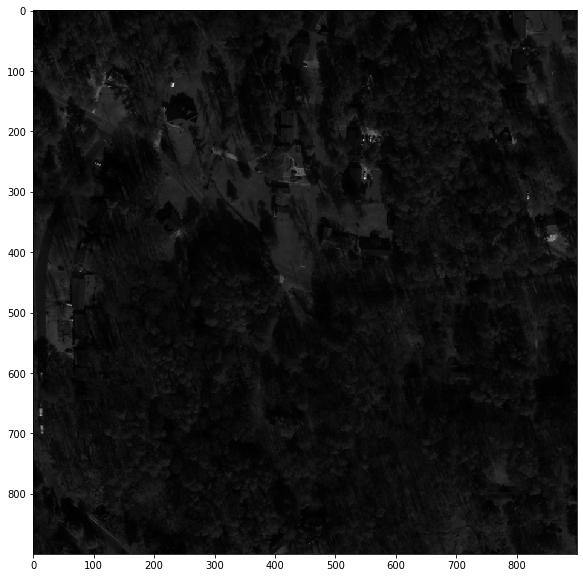

In [2]:
import solaris as sol
from solaris.data import data_dir
import os
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union

image = skimage.io.imread(os.path.join(data_dir, 'sample_geotiff.tif'))
f, axarr = plt.subplots(figsize=(10, 10))
plt.imshow(image, cmap='gray')

This is a panchromatic image of an area in Atlanta. Can you pick out the buildings?

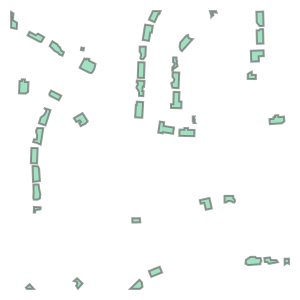

In [3]:
gdf = gpd.read_file(os.path.join(data_dir, 'geotiff_labels.geojson'))
cascaded_union(gdf.geometry.values)

This is a convenient visualization built into Jupyter notebooks, but what are the objects it's showing?

In [4]:
for geom in gdf.geometry[0:3]:
    print(geom)

POLYGON ((733633.9175634939 3724917.327059259, 733644.0265766426 3724916.940842033, 733643.0617814267 3724892.157892002, 733632.9527424234 3724892.544111664, 733633.9175634939 3724917.327059259))
POLYGON ((733653.1326928001 3724949.324520395, 733648.855268121 3724922.585283833, 733642.8083045555 3724925.412150491, 733636.7858552651 3724926.852379398, 733638.0802132279 3724931.256500166, 733642.4909367257 3724931.19752501, 733643.0288657807 3724937.691814653, 733641.6848001335 3724942.564334524, 733641.2768538269 3724944.829464028, 733643.2673519406 3724949.61678283, 733653.1326928001 3724949.324520395))
POLYGON ((733614.6924076959 3725025.91770485, 733618.2329309537 3725025.759830723, 733618.3612589325 3725028.493043821, 733623.4073750104 3725028.260883178, 733623.2266384158 3725024.250133027, 733629.2206437828 3725023.974487836, 733628.4996830962 3725008.231178387, 733624.4670389239 3725005.347326851, 733613.7709592135 3725005.83023022, 733614.6924076959 3725025.91770485))


A bunch of Well-Known-Text (WKT)-formatted strings. Let's convert these into something a deep learning model can use.

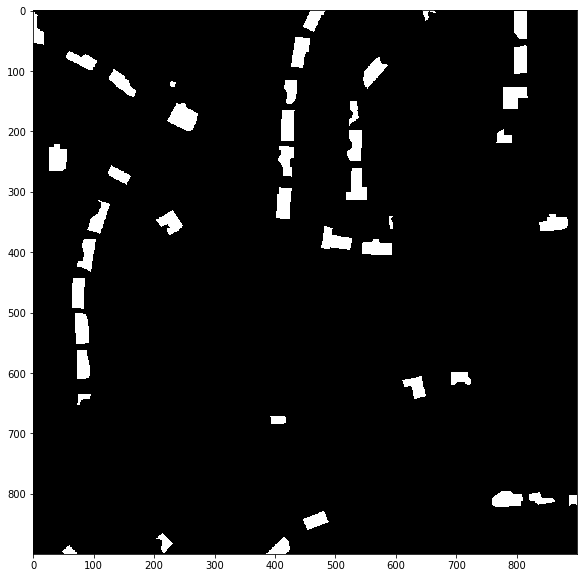

In [5]:
fp_mask = sol.vector.mask.footprint_mask(df=os.path.join(data_dir, 'geotiff_labels.geojson'),
                                      reference_im=os.path.join(data_dir, 'sample_geotiff.tif'))
f, ax = plt.subplots(figsize=(10, 10))
plt.imshow(fp_mask, cmap='gray')

This is a `numpy` array of shape `(900, 900)` with `0` at non-building pixels and `255` at building pixels.

## Polygon outlines

What if we want to find all of the edges of these buildings? In that case, we can use the [solaris.vector.mask.boundary_mask()](../../api/vector.rst#solaris.vector.mask.boundary_mask) function. There are a few arguments to this function:

- `footprint_msk`: Instead of providing `df` as you did for [footprint_mask()](../../api/vector.rst#solaris.vector.mask.footprint_mask), for this function you can provide the footprint output. (Don't worry, if you didn't make one yet, you can still just provide the `df` argument and other [footprint_mask()](../../api/vector.rst#solaris.vector.mask.footprint_mask) arguments - `solaris` will create it behind the scenes)
- `out_file`: Same as earlier.
- `reference_im`: Same as earlier.
- `boundary_width`: The width, in pixel units, of the outline around the polygon. Defaults to `3`.
- `boundary_type`: Should the boundary be inside the polygon (`"inner"`, the default value) or outside (`"outer"`)?
- `burn_value`: Same as earlier, still defaults to `255`.

You can also provide additional keyword arguments to pass to [footprint_mask()](../../api/vector.rst#solaris.vector.mask.footprint_mask) if that needs to be made first.

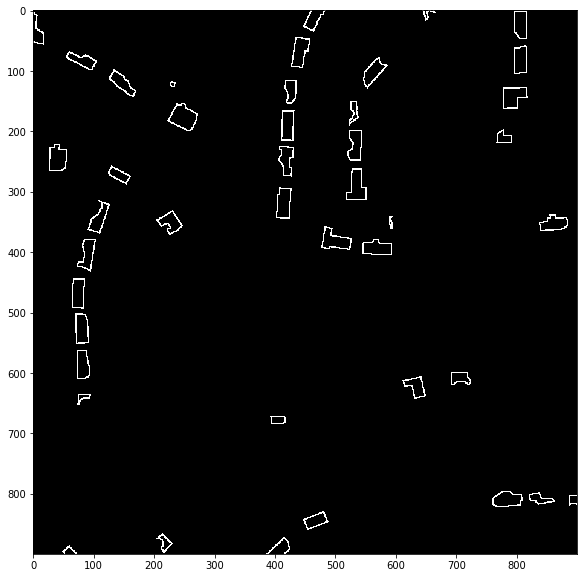

In [6]:
b_mask = sol.vector.mask.boundary_mask(fp_mask, boundary_width=5)
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(b_mask, cmap='gray')

Some of the SpaceNet competitors have found this type of mask useful for helping separate nearby objects.

## Polygon contact points

What about training a model to specifically find places where buildings are near each other? This can be helpful for the same purpose as the edges. The [solaris.vector.mask.contact_mask()](../../api/vector.rst#solaris.vector.mask.contact_mask) function creates this.

Its arguments:


- `contact_spacing`: An `int` specifying how close objects have to be for contact points to be labeled. Default value is 10.
- `meters`: A boolean argument indicating whether or not the `contact_spacing` argument is in meters. Defaults to `False`, in which case it's in pixels.

This function also takes `df` (__required__), `out_file`, `reference_im`, `geom_col`, `do_transform`, `affine_obj`, `shape`, `out_type`, and `burn_value` as arguments, which have the same meanings as in [solaris.vector.mask.footprint_mask()](../../api/vector.rst#solaris.vector.mask.footprint_mask).

Let's create some contact points!

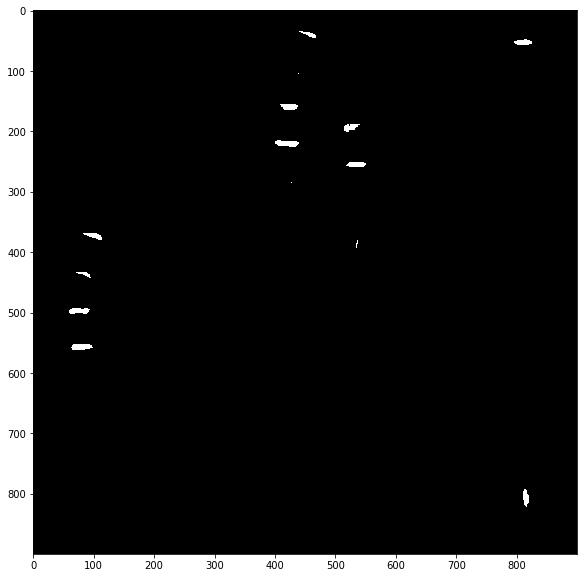

In [7]:
c_mask = sol.vector.mask.contact_mask(df=os.path.join(data_dir, 'geotiff_labels.geojson'),
                                      reference_im=os.path.join(data_dir, 'sample_geotiff.tif'),
                                      contact_spacing=10, meters=True)
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(c_mask, cmap='gray')

Finally, let's create a three-channel mask containing all three of these layers! The [solaris.vector.mask.df_to_px_mask()](../../api/vector.rst#solaris.vector.mask.df_to_px_mask) function takes all of the same arguments as above, plus `channels`, a list specifying which of the three types of masks should be included. We'll make one that has them all!

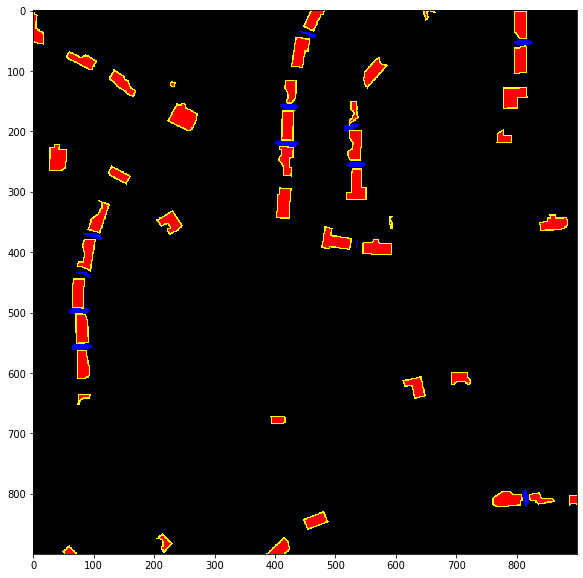

In [8]:
fbc_mask = sol.vector.mask.df_to_px_mask(df=os.path.join(data_dir, 'geotiff_labels.geojson'),
                                         channels=['footprint', 'boundary', 'contact'],
                                         reference_im=os.path.join(data_dir, 'sample_geotiff.tif'),
                                         boundary_width=5, contact_spacing=10, meters=True)
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(fbc_mask)

That mask looks ready to train a solid model!

## Road network masks

Finally, we can use linestrings to create a road network. Here we're going to use a different sample input image and geojson alongside the [solaris.vector.mask.road_mask()](../../api/vector.rst#solaris.vector.mask.road_mask). This function takes many of the same arguments as the earlier functions: `df` (__required__), `meters`, `out_file`, `reference_im`, `geom_col`, `do_transform`, `affine_obj`, `shape`, `out_type`, `burn_value`, and `burn_field`.

This function also takes `width`, which specifies the width of the road network (in pixels unless `meters=True`).

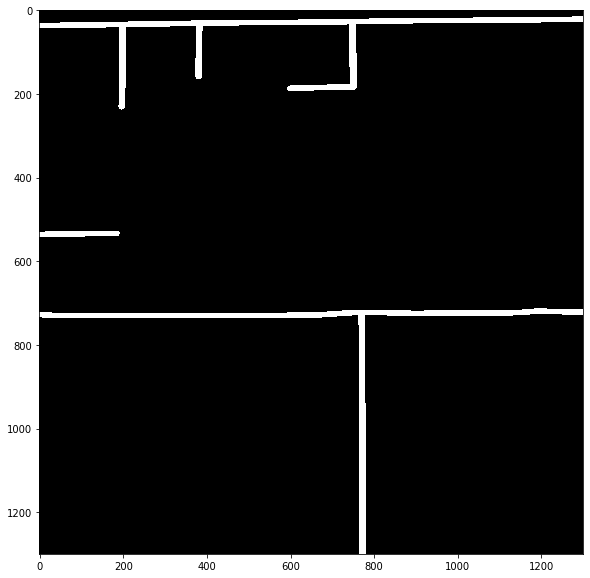

In [9]:
road_mask = sol.vector.mask.road_mask(os.path.join(data_dir, 'sample_roads_for_masking.geojson'),
                                      reference_im=os.path.join(data_dir, 'road_mask_input.tif'),
                                      width=4, meters=True)

f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(road_mask, cmap='gray')

And there we go! Enjoy creating masks!! If you want to do this in batch without running python code, [the make_masks CLI function](cli_mask_creation.ipynb) allows you to do so, with the option of parallelizing some aspects.